# Computational Approaches to the Study of Food Sign Patterns
Today, we're going to explore the ways in which restaurants of different cuisines describe food on their menus. Specifically, we're interested in the following questions about food cultures in Chicago:
1. Are there patterns in the ways in which particular cuisine genres describe food on menus?
    * Identification of indexical/iconic legisigns that position a particular cuisine within a cuisine, or social status (which can then be used by consumers to position themselves in the same light via social media posts, and so on)
2. Are these cuisines (and/or menu discourse patterns identified in #1) geographically patterned?
    * Identification of dicent indexical legisigns that point to a particular cuisine or broader menu discourse pattern on the basis of spatial location
    
First, let's load our packages. In order to run this notebook, you will need to install the `folium` package, which is available to install through the Anaconda Navigator or on the command line via the command `conda install -c conda-forge folium`

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from gensim import corpora, models
from sklearn.manifold import TSNE
import folium

# Some Functions from Last Time to get us started:
def get_wordnet_pos(word):
    import nltk

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

def get_lemmas(text):
    import nltk

    # Combine list elements together into a single string for analysis
    text = ' '.join(text)

    stop = nltk.corpus.stopwords.words('english') + list(string.punctuation) + ["amp", "39"]
    tokens = [i for i in nltk.word_tokenize(text.lower()) if i not in stop]
    lemmas = [nltk.stem.WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t)) for t in tokens]
    return lemmas

def plot_top_tfidf(series, data_description):
    import nltk

    # Apply 'get lemmas' function to any Pandas Series that we pass in to get lemmas for each row in the Series
    lemmas = series.apply(get_lemmas)

    # Initialize Series of lemmas as Gensim Dictionary for further processing
    dictionary = corpora.Dictionary([i for i in lemmas])

    # Convert dictionary into bag of words format: list of (token_id, token_count) tuples
    bow_corpus = [dictionary.doc2bow(text) for text in lemmas]

    # Calculate TFIDF based on bag of words counts for each token and return weights:
    tfidf = models.TfidfModel(bow_corpus)
    tfidf_weights = tfidf[bow_corpus[0]]

    # Sort TFIDF weights highest to lowest:
    sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

    # Plot the top 10 weighted words:
    top_10 = {dictionary[k]:v for k,v in sorted_tfidf_weights[:10]} # dictionary comprehension
    plt.plot(list(top_10.keys()), list(top_10.values()), label=data_description)
    plt.xticks(rotation='vertical')
    plt.title('Top 10 Lemmas (TFIDF) for ' + data_description);

    return

ModuleNotFoundError: No module named 'folium'

______________________________

In order to answer our research questions, we need to scrape menu data from restaurants around Chicago. The easiest way to scrape data is to find a central aggregator that uses a common website format (rather than multiple website designs, which would require us to write separate scraping functions for each one). For today's hands-on session, we're going to be scraping menu data from allmenus.com, the menu repository used and updated in the service of GrubHub (it also contains restaurants that do not takeout, however).

Let's first figure out how we can scrape a menu off of a single restaurant's allmenus.com webpage (Francesca's Bryn Mawr, in the Edgewater neighborhood): https://www.allmenus.com/il/chicago/22019-francescas-bryn-mawr/menu/

In [2]:
# Read in the HTML page using the Requests library, just like we did for API calls
html = requests.get("https://www.allmenus.com/il/chicago/22019-francescas-bryn-mawr/menu/") # also special object, create with get thing

# Use BeautifulSoup to parse the text as an HTML, so that we can select the elements we want to 
soup = BeautifulSoup(html.text, "html.parser") # create beautiful soup object (input is request object and a parser)
# .text takes html request object and sees as strings

In [8]:
restaurant_data = soup.find('script', type='application/ld+json') #.find is one of the functions for beautiful soup objects (gives the first result)
# 'script' is tag we are searching for
# set strict to False, so that control characters like \n are allowed within the text:
restaurant_data_json = json.loads(restaurant_data.text, strict=False)
# json is special object - transform into this --- better to go text > JSON > pd dataframe

In [18]:
nested_items = [section['hasMenuItem'] for section in restaurant_data_json['hasMenu'][0]['hasMenuSection']]
name = [j['name'] for i in nested_items for j in i]
description = [j['description'] for i in nested_items for j in i]

We don't just want to be able to scrape a single restaurant's information, though. We want to scrape many restaurants' menus. Let's take a look at how we might do that. First, let's see how we can scrape restaurant links from the popularity sorted list of restaurants on allmenus.com. We'll specifically look at the most popular Italian restaurants.

In [2]:
# Get cuisine's popularity-sorted list of restaurants
html = requests.get('https://www.allmenus.com/il/chicago/-/italian/')
soup = BeautifulSoup(html.text, "html.parser")

# Find links where class != grubhub (these take you to Grubhub's website, rather than the allmenus page we want)
restaurant_anchors = soup.find('ul', class_="restaurant-list").findAll("a", class_=None)
restaurant_links = ['https://www.allmenus.com' + i.get('href') for i in restaurant_anchors[:5]]

In [4]:
soup

<!DOCTYPE html>

<html lang="en">
<head>
<title>Italian restaurants and menus in Chicago, IL - Allmenus.com</title>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<meta content="Chicago's Italian restaurant and menu guide. View menus, maps, and reviews for popular Italian restaurants in Chicago, IL." name="description"/>
<meta content="Restaurant, food, menu" name="keywords"/>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=0" name="viewport"/>
<link href="/static/manifest.json" rel="manifest"/>
<meta content="#007AFF" name="theme-color"/>
<meta content="#007AFF" name="msapplication-TileColor"/>
<meta content="yes" name="mobile-web-app-capable"/>
<meta content="Allmenus.com" name="application-name"/>
<meta content="yes" name="apple-mobile-web-app-capable"/>
<meta content="black" name="apple-mobile-web-app-status-bar-style"/>
<meta content="Chicago's Italian restaurant and menu guide. View menus, maps, and reviews for popular Ital

We can formalize this process into a function that will the take the top "n" menus for each cuisine in a list of cuisines. In the file is a function that does exactly that. Let's walk through how it works...

In [26]:
def get_menu_data(url, uid, cuisine):
    '''
    Takes allmenus.com url and a restaurant unique id number
    (so that restaurants with the same name are uniquely identifiable)
    Returns Dictionary: {UID:{Cuisine, Restaurant Name,
                              Coordinates, Menu:{Dish Names, Dish Descriptions}
                        }
    '''
    # Get HTML, parse it, and identify JSON containing Restaurant/Menu Data
    html = requests.get(url)
    soup = BeautifulSoup(html.text, "html.parser")
    restaurant_data = soup.find('script', type='application/ld+json')
    try:
        # set strict to False, so that control characters like \n are allowed within the text:
        restaurant_data_json = json.loads(restaurant_data.text, strict=False)
    except:
        return {uid: {'Cuisine': cuisine,
                       'Restaurant': None,
                       'Coordinates': None,
                       'Menu Items': None,
                       'Item Descriptions': None,
                       'URL': url
                }}
    try:
        # Store each menu item (a dictionary) into nested_items variable for retrieving item names and descriptions below:
        nested_items = [section['hasMenuItem'] for section in restaurant_data_json['hasMenu'][0]['hasMenuSection']]

        # Store Data for individual menu/restaurant in a dictionary to enable easy aggregation into a Pandas DataFrame:
        menu_data = {uid: {'Cuisine': cuisine,
                       'Restaurant': restaurant_data_json['name'],
                       'Coordinates': (restaurant_data_json['geo']['latitude'], restaurant_data_json['geo']['longitude']),
                       'Menu Items': [j['name'] for i in nested_items for j in i],
                       'Item Descriptions': [j['description'] for i in nested_items for j in i],
                       'URL': url
                }}
    except:
        menu_data = {uid: {'Cuisine': cuisine,
                       'Restaurant': restaurant_data_json['name'],
                       'Coordinates': (restaurant_data_json['geo']['latitude'], restaurant_data_json['geo']['longitude']),
                       'Menu Items': None,
                       'Item Descriptions': None,
                       'URL': url
                }}

    return menu_data

def scrape_top_menus(cuisine_list, topn=10):
    # Create a Dictionary for holding every cuisine's restaurant/menu data:
    cuisine_dict = {}
    # Incremental count for assigning unique identification numbers to each restaurant
    count = 0

    # Scrape top n (parameter topn) restaurant links from allmenus.com for each cuisine:
    for cuisine in cuisine_list:
        # Get cuisine's popularity-sorted list of restaurants
        html = requests.get('https://www.allmenus.com/il/chicago/-/' + cuisine + '/')
        soup = BeautifulSoup(html.text, "html.parser")

        # Find links where class != grubhub (these take you to Grubhub's website, rather than the allmenus page we want)
        restaurant_anchors = soup.find('ul', class_="restaurant-list").findAll("a", class_=None)
        restaurant_links = ['https://www.allmenus.com' + i.get('href') for i in restaurant_anchors[:topn]]

        # Loop through each Restaurant's allmenus.com webpage and get its menu data:
        menu_dict = {}
        for restaurant in restaurant_links:
            dict_temp = {}
            dict_temp = get_menu_data(url = restaurant,
                                         uid = count,
                                         cuisine=cuisine)
            menu_dict.update(dict_temp)
            count += 1
        cuisine_dict.update(menu_dict)


    return pd.DataFrame(cuisine_dict).T

# Scrape top 100 menus for each cuisine (total of 1000 menus):
# menu_df = scrape_top_menus(['italian','soul-food', 'latin-american', 'gastropub', 'polish', 
#                            'late-night', 'thai', 'chinese', 'korean', 'vegan_vegetarian'], topn=100)

In [23]:
# Read in JSON of scraped data (700 entries after dropping items that have NA values)
# menu_df.to_json('menu_df_top100.json') # keep this here as the top 10 option for a sparser dataset for testing; although I probably want to drop late-night and add in American (New), Pizza
menu_df = pd.read_json('menu_df_top100.json')
menu_df.dropna(inplace=True)
menu_df.head()

,Coordinates,Cuisine,Item Descriptions,Menu Items,Restaurant,URL
1,"[41.86571, -87.623716]",italian,"[, , , , , , House made breadsticks with a pep...","[Can of Soda, Bottled Water, Joe&#39;s Peach T...",Ameritalia,https://www.allmenus.com/il/chicago/423696-ame...
10,"[41.881779, -87.660881]",italian,"[Our famous meatballs, romaine salad and red w...","[Meatball Salad, Fresh Tomato Bruschetta, Bake...",Viaggio Ristorante &amp; Lounge,https://www.allmenus.com/il/chicago/273383-via...
100,"[42.00238, -87.816322]",soul-food,"[Country potatoes, ham, sausage, bacon, green ...","[Barney Skillet Breakfast, Hoedown Skillet Bre...",Firewater Saloon,https://www.allmenus.com/il/chicago/378974-fir...
101,"[41.975418, -87.752291]",soul-food,"[, 7oz fried catfish filet&amp;comma; romaine ...","[Shrimp Po Boy Sandwich, Catfish Po Boy Sandwi...",Mother Cluckers Kitchen,https://www.allmenus.com/il/chicago/478189-mot...
102,"[41.801758, -87.589005]",soul-food,"[, 7 oz boneless chop, fried, house made BBQ s...","[Gumbo Bowl, Pork Chop on a Stick, Fried Ribs,...",Porkchop,https://www.allmenus.com/il/chicago/415241-por...


Now that we have our data loaded, let's first take a look to see if there any clear spatial patterns in cuisines. We will use Python's Folium package to create interactive maps that make it easier to explore our data geographically.

In [24]:
# Plot Folium map: see how we can navigate around it
m = folium.Map(zoom_start=12, location=[41.8507, -87.6340], tiles='CartoDB positron')

# Plot a point on top of it, indexing coordinates for restaurant with index '1':
folium.Marker(menu_df['Coordinates'][1]).add_to(m)

# Display map
m

Let's write a function to display more information on the map, so that we can identify specific cuisines and restaurant names for all of the menus in our dataset and identify general spatial patterns in restaurant/cuisine location. Although, the plot is busy, we can see some distinct patterns that emerge in where certain cuisines are located. Often, as we would expect centered in areas where ethnic communities live. Also, though, in the case of Gastropubs, we see a distinct pattern where they are most prominent in River North and the West Loop, both areas where a large number of working professionals live -- perhaps indicating a cultural ties to these types of restaurants in particular.

In [25]:
# We can use a function to make this a bit easier, adding popup content with restaurant name + custom icon
def make_folium_pt_map(menu_df):
    m = folium.Map(zoom_start=12, location=[41.8507, -87.6340], tiles='CartoDB positron')

    for point in menu_df.index:
        popup_content = '<b>Restaurant: </b>' + menu_df['Restaurant'][point] + '\n' + '<b>Cuisine: </b>' + menu_df['Cuisine'][point].capitalize()
        color_cuisine = {'italian': 'red','soul-food': 'blue', 'latin-american': 'green', 'gastropub': 'purple',
                         'polish': 'orange', 'late-night': 'darkred', 'thai': 'black', 'chinese': 'pink',
                         'korean': 'darkblue', 'vegan_vegetarian':'lightgreen'
                        }
        color_icon_body = color_cuisine[menu_df['Cuisine'][point]]

        folium.Marker(menu_df['Coordinates'][point],
                      popup=popup_content,
                      icon=folium.Icon(color=color_icon_body,icon_color='white', icon='cutlery')
                     ).add_to(m)

    # Inspired by: https://medium.com/@bobhaffner/creating-a-legend-for-a-folium-map-c1e0ffc34373
    # ideally, will need to loop it so that final legend_html includes as many color icons as I want; just write something that
    # assigns these colors from the color_icon dictionary
    legend_html = '''
             <div style="position: fixed;
             top: 50px; right: 50px; width: 150px; height: 325px;
             border:2px solid grey; z-index:9999; font-size:14px;
             ">&nbsp; Cuisine Color Code<br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:red"></i>&nbsp; Italian<br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:blue"></i>&nbsp; Soul Food<br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:green"></i>&nbsp; Latin American<br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:purple"></i>&nbsp; Gastropub<br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:orange"></i>&nbsp; Polish <br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:darkred"></i>&nbsp; Late Night<br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:black"></i>&nbsp; Thai<br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:pink"></i>&nbsp; Chinese<br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:darkblue"></i>&nbsp; Korean<br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:lightgreen"></i>&nbsp; Vegan/Vegetarian
             </div>
            '''
    m.get_root().html.add_child(folium.Element(legend_html))
    return m

make_folium_pt_map(menu_df)

Let's take a look at whether or not there are any semantic patterns in the use of language across the different cuisines. First, let's look to see if there are any words that are conventionally used in some cuisines and not in others. Let's use our functions from last week's hands-on session to plot the top TFIDF scores for several genres (already defined in the first code block).

We can see from the plots that the ways in which different cuisines describe the food is circumscribed by cuisine genre--highlighting distinct modes of describing food in Chicago, specific to particular food cultures. Restaurants seem to be positioning themselves in their cuisine genre with different sorts of language (replicating dicent indexical legisigns in their menus).

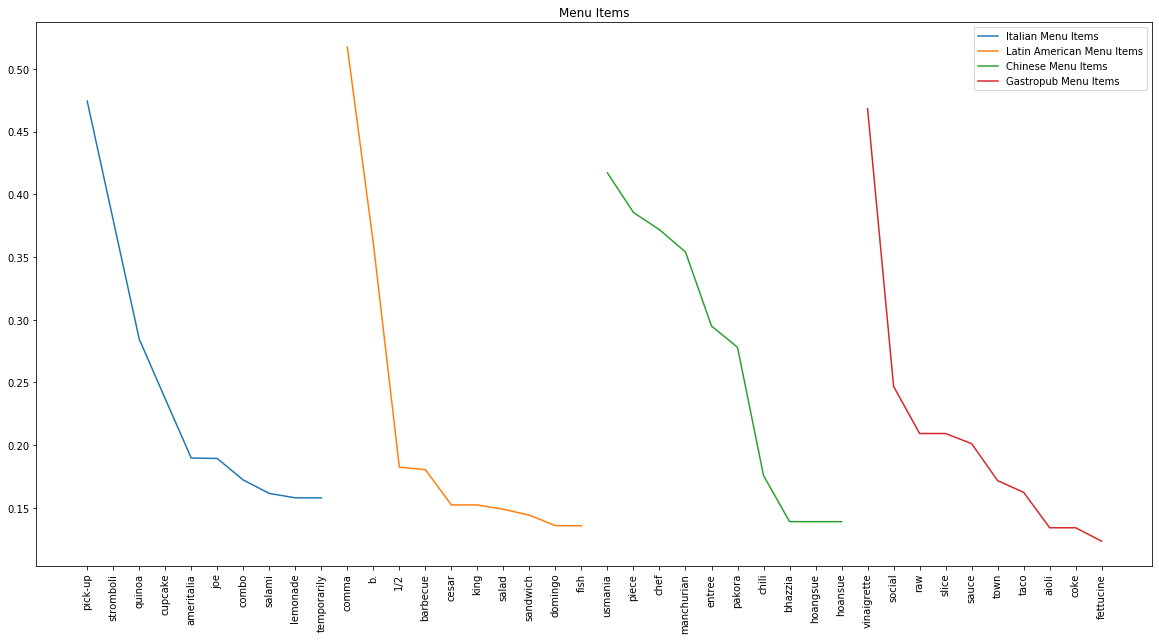

In [41]:
# Only taking a selection to look at, so that we can easily see the words on the x-axis of the plot:
plt.figure(figsize=(20,10))
plot_top_tfidf(menu_df[menu_df['Cuisine'] == 'italian']['Menu Items'], 'Italian Menu Items')
plot_top_tfidf(menu_df[menu_df['Cuisine'] == 'latin-american']['Menu Items'], 'Latin American Menu Items')
plot_top_tfidf(menu_df[menu_df['Cuisine'] == 'chinese']['Menu Items'], 'Chinese Menu Items')
plot_top_tfidf(menu_df[menu_df['Cuisine'] == 'gastropub']['Menu Items'], 'Gastropub Menu Items')
plt.legend()
plt.title('Menu Items');

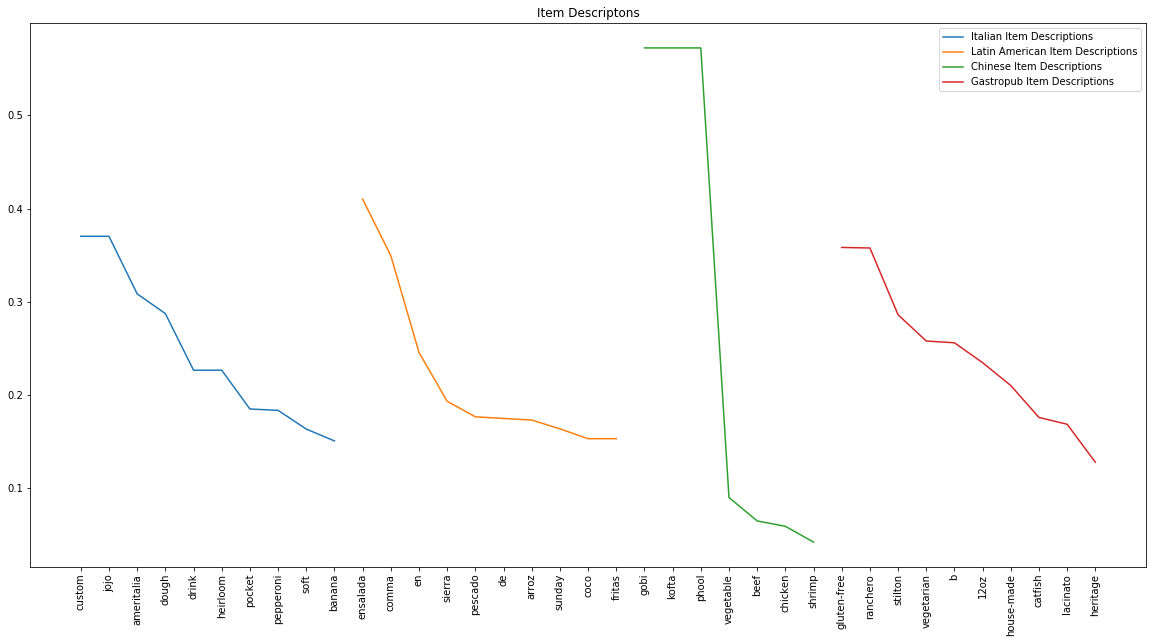

In [42]:
plt.figure(figsize=(20,10))
plot_top_tfidf(menu_df[menu_df['Cuisine'] == 'italian']['Item Descriptions'], 'Italian Item Descriptions')
plot_top_tfidf(menu_df[menu_df['Cuisine'] == 'latin-american']['Item Descriptions'], 'Latin American Item Descriptions')
plot_top_tfidf(menu_df[menu_df['Cuisine'] == 'chinese']['Item Descriptions'], 'Chinese Item Descriptions')
plot_top_tfidf(menu_df[menu_df['Cuisine'] == 'gastropub']['Item Descriptions'], 'Gastropub Item Descriptions')
plt.legend()
plt.title('Item Descriptons');

Let's add a bit more contextual information to our analysis of menu discourse. Frequency measures like TFIDF leave out a great deal of information about the context in which individual words are used -- notably what words are semantically and syntactically related to a given word in a sentence or string of words. This information could be useful if we're trying to understand the conventional interpretant of a word, for instance.

One way of representing the relationships between individual words is via a technique called word2vec, transforming words into vector representations in a high-dimensional vector space. Word vectors that share common contexts in a corpus of texts (in our case, a collection of menus) will be [positioned close to one another in the vector space](https://en.wikipedia.org/wiki/Word2vec). Thus, by examining the similarity of words in a vector space, we can begin to identify broader discourse patterns for particular words and identify which words tend to be semantically and syntactically related to one another. We could do this on the level of an individual cuisine, or on the level of all of our entire corpus of menus to identify conventional relationships between language about food preparation, ingredients, and descriptors within a particular food culture

We will be using Gensim's implementation of Word2Vec (see cell below). For more information on the Word2Vec parameter options, consult the [documentation](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec). Here, I make use of the `min_count` parameter, which specifies that a lemma must appear a minimum of 10 times in the corpus to be considered in the model and the `window` parameter, which set the maximum distance between a given word and a predicted word (i.e. takes into account more or less context within a sentence). I also set the `workers` parameter to 8 (this parameter can be reduced or increased, depending on the capabilities of your machine) to speed up processing on multi-core/thread computers. By default, the model produces 100-dimensional vector representations of each word. Distance between word vectors can then be measured via cosine distance (if you mathematically derive statistical correlation, you can see that this is basically unnormalized correlation between two words)

In [45]:
# treat each Menu's text entries as a "text" (list of lemmas) in a "corpus" (Pandas series of lists of lemmas)
# Don't run this on the full dataset; you can load the model below to use it in the remaining exercises
#corpus = menu_df['Item Descriptions'].apply(get_lemmas)
#model = models.word2vec.Word2Vec(corpus, min_count=20, window=10, workers=8)
#model.save('w2v_model_top100.model')
model = models.KeyedVectors.load('w2v_model_top100.model')

Once we transform our text data, we can look to see which words are included in our model:

In [46]:
# For each word that is above the minimum count of 10 (key), we have a vector model (value):
model.vocab

{'house': <gensim.models.keyedvectors.Vocab at 0x2cb143a4a20>,
 'make': <gensim.models.keyedvectors.Vocab at 0x2cb143a4fd0>,
 'pepperoni': <gensim.models.keyedvectors.Vocab at 0x2cb143a41d0>,
 'center': <gensim.models.keyedvectors.Vocab at 0x2cb143a4780>,
 'serve': <gensim.models.keyedvectors.Vocab at 0x2cb143a4a90>,
 'marinara': <gensim.models.keyedvectors.Vocab at 0x2cb143a4c88>,
 'sauce': <gensim.models.keyedvectors.Vocab at 0x2cb143a4b38>,
 'fry': <gensim.models.keyedvectors.Vocab at 0x2cb143a4be0>,
 'chicken': <gensim.models.keyedvectors.Vocab at 0x2cb143a40b8>,
 'tender': <gensim.models.keyedvectors.Vocab at 0x2cb143a4198>,
 'orange': <gensim.models.keyedvectors.Vocab at 0x2cb143a4320>,
 'roast': <gensim.models.keyedvectors.Vocab at 0x2cb143a4438>,
 'banana': <gensim.models.keyedvectors.Vocab at 0x2cb143a4550>,
 'pepper': <gensim.models.keyedvectors.Vocab at 0x2cb143a4a58>,
 'stuffed': <gensim.models.keyedvectors.Vocab at 0x2cb143a4b70>,
 'italian': <gensim.models.keyedvectors.Vo

We can also take a look at our word vector representations:

In [47]:
# This is the 100-dimensional representation of a word:
model['garlic']

array([-0.9340344 ,  1.0182654 ,  0.43340603, -0.9361065 ,  1.1666256 ,
        0.3925275 ,  2.1436336 , -0.1397898 , -0.8452646 , -0.6460656 ,
        0.8107429 , -0.48267862, -0.07487705, -0.55252165,  0.04813116,
        0.4083206 , -0.20243247,  0.08483667,  0.57301635, -1.1628865 ,
        0.46157017, -1.1112396 , -1.1307625 , -0.81017584, -0.48246965,
        1.6480253 ,  0.21368666,  0.36557034,  1.5267377 ,  1.1229407 ,
        0.01617158, -1.3472326 ,  0.10663045,  1.1572963 ,  0.8858561 ,
       -0.04827853, -1.3527312 , -0.12556975,  0.81353277,  0.3640842 ,
       -0.28883427, -0.2713029 , -1.4640204 , -0.06704541, -0.6923081 ,
        1.0447007 , -0.06877369, -0.12998664, -0.6147198 , -0.01976262,
        0.04146164, -0.50247455,  0.15420145,  0.38571346,  0.289918  ,
        0.84756434,  0.5210378 , -0.50001484, -0.14115176, -0.6809033 ,
       -0.38535446,  0.2832237 , -0.63424736, -1.4650056 ,  0.36533618,
        0.51491004, -0.22379051, -0.22030419, -0.46534216, -0.24

It's hard to visualize the relationships between 100-dimensional vectors, though. Humans are really bad at visualizing anything above 3 dimensions. Let's project these relationships onto a two-dimensional plane and take a look at how the different words relate to one another. We can use a function to reduce the dimensionality via a technique called [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

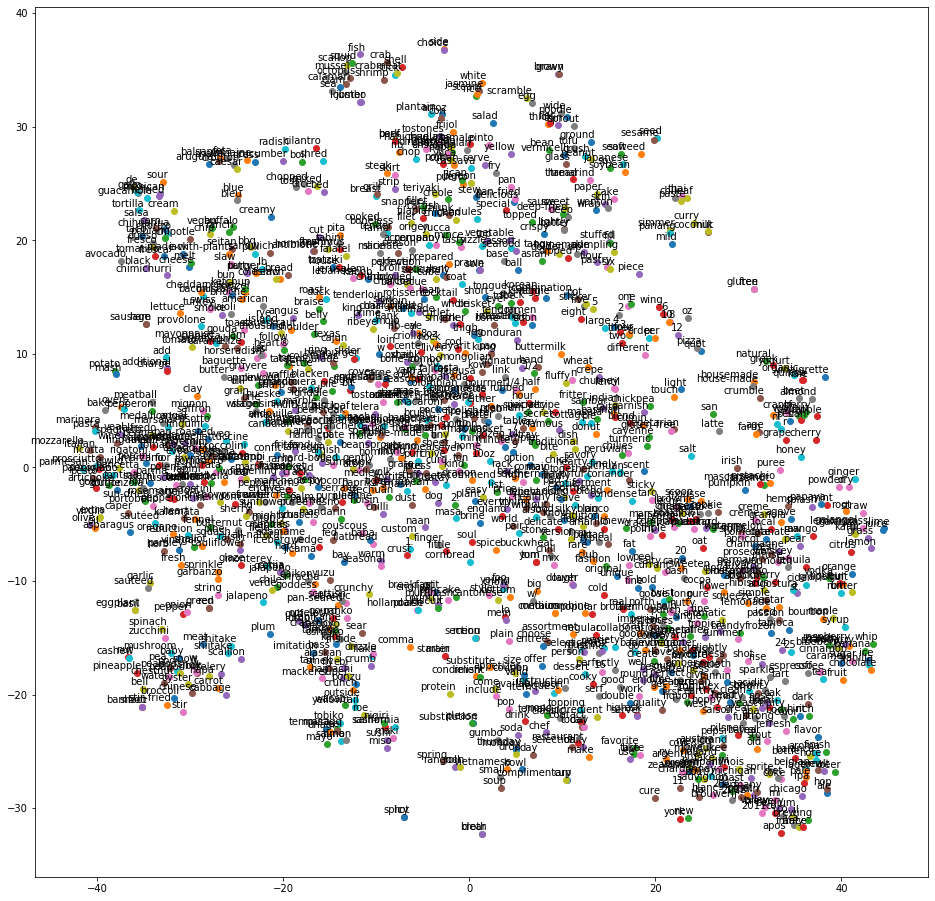

In [48]:
def word2vec_tsne_plot(model):
    '''
    Creates and TSNE model and plots it
    '''
    labels = []
    tokens = []

    for word in model.vocab:
        tokens.append(model[word])
        labels.append(word)

    # Reduce 100 dimensional vectors down into 2-dimensional space so that we can see them
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    return

word2vec_tsne_plot(model)

We can definitely see some semantic clusters here that make sense together. This plot is pretty busy, though, and could be hard to read with more data. If we're trying to figure out the semantic and syntactic relationships for a particular word or set of words, we can print the closest values out as a list:

In [49]:
# This is pretty busy and hard to read, though; if we're trying to figure out the interpretant of a single word, we might consult
# the most_similar function to identify the words that are most similar --i.e. the words it is syntactically/semantically related to in a particular cuisine
print(model.most_similar('garlic'))

[('sauteed', 0.8091985583305359), ('dice', 0.6805795431137085), ('parsley', 0.6780210137367249), ('paprika', 0.6750020384788513), ('herb', 0.6662529110908508), ('eggplant', 0.662540853023529), ('boneless', 0.6503599882125854), ('w', 0.647678792476654), ('sautéed', 0.6455572843551636), ('zucchini', 0.61823970079422)]


Building on this representation of single words as vectors, we can also begin to represent full sentences and documents as aggregations of these vectors. For instance, while it is interesting to see how individual words are conventionally related to one another, we might also be interested in how the overall language in a menu compares to that of other menus, or which genres or geographic locations are most likely to use particular discourse legisigns (i.e. which menus use language most consistent with that of food connoisseurs? Are these geographic legisigns, specific to menus in a particular region? Are they genre-based patterns, specific to a particular cuisine?).

To do this, we can use a technique called Doc2Vec, which essentially averages together the different word vectors within a document (in our case, a menu) and takes into account their context within the document as a whole. I recommend reading the [original paper on this approach](https://cs.stanford.edu/~quocle/paragraph_vector.pdf) for more detail on the underlying logic.

In [40]:
# Can train doc2vec model using the same parameters as word2vec, but need to add document tags for each menu using gensim's 'TaggedDocument function'
#menu_lemmas = menu_df['Item Descriptions'].apply(get_lemmas)
#doc_corpus = [models.doc2vec.TaggedDocument(words=l, tags=[str(i)]) for i, l in enumerate(menu_lemmas)]

# Don't run if not needed; will take a while to run. Saved Model can be loaded below
#doc_model = models.doc2vec.Doc2Vec(doc_corpus, min_count=200, window=10, workers=8)
#doc_model.save('doc_model_top100.model')
doc_model = models.KeyedVectors.load('doc_model_top100.model')

Let's project these document vectors in 2-dimensional space as well so that we can visualize them. It looks like Italian and Thai cuisines use especially distinct discursive practices and that Vegan/Vegetarian is seemingly similar in their language use to Italian. It would be interesting to a bit more digging into why this is the case. Why is their discourse similar to Italian? It also appears that the majority of gastropubs are off to one side of the plot, employing similar discursive strategies to one another, although they are not as distinct as the aforementioned cuisines. It seems like these restaurants conventionally index a cuisine-specific language more than the others (i.e. replicate dicent indexical legisigns).

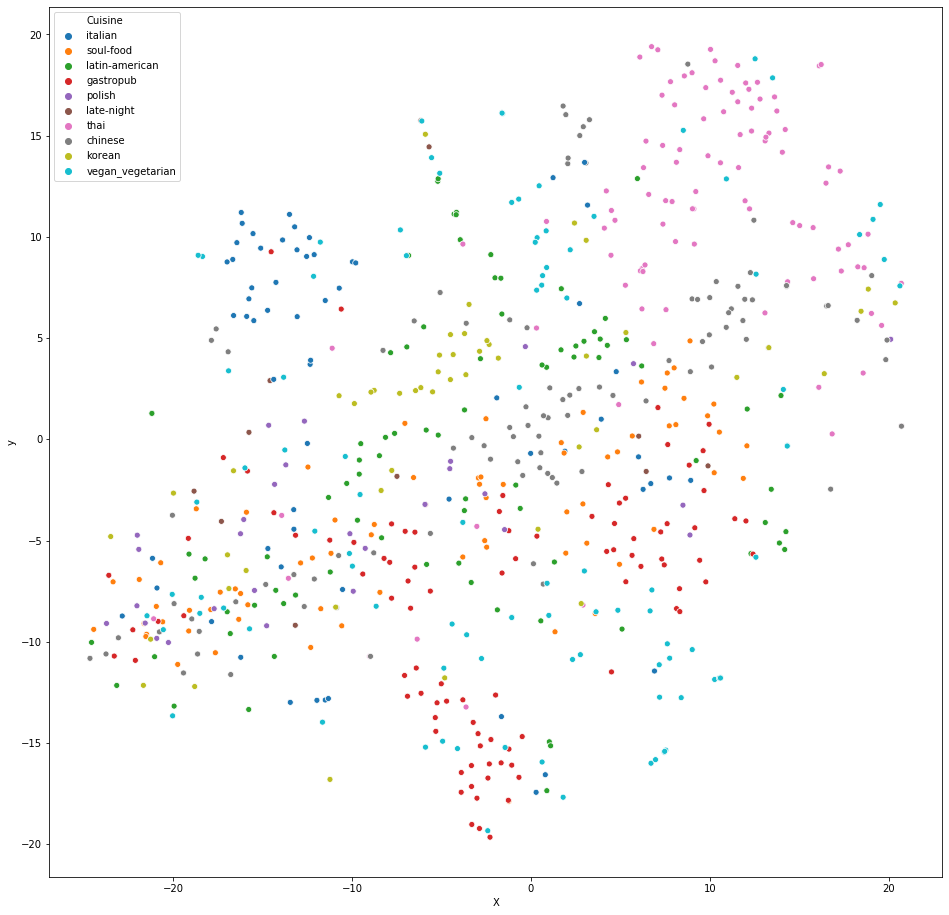

In [41]:
def doc2vec_tsne_plot(doc_model, labels):

    tokens = []
    for i in range(len(doc_model.docvecs.vectors_docs)):
        tokens.append(doc_model.docvecs.vectors_docs[i])

    # Reduce 100 dimensional vectors down into 2-dimensional space so that we can see them
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    X = [doc[0] for doc in new_values]
    y = [doc[1] for doc in new_values]

    # Combine data into DataFrame, so that we plot it easily using Seaborn
    df = pd.DataFrame({'X':X, 'y':y, 'Cuisine':labels})
    plt.figure(figsize=(16, 16))
    sns.scatterplot(x="X", y="y", hue="Cuisine", data=df)
    return

doc2vec_tsne_plot(doc_model1, menu_df['Cuisine'])

In [31]:
# Take a look at the underlying vector representation of the first document
doc_model.docvecs.vectors_docs[0]

array([ 6.63768277e-02,  4.25863117e-02, -2.84601375e-03, -7.59573579e-02,
        1.23380627e-02,  1.54985055e-01,  6.09887019e-02, -9.05883685e-02,
        1.78800106e-01,  1.78881004e-01, -9.43188518e-02,  1.59097001e-01,
       -1.05091184e-01,  8.06638375e-02, -1.07662350e-01,  4.43694219e-02,
        6.58186525e-02, -6.85966611e-02, -2.66100559e-02,  9.15201157e-02,
        1.95028179e-03, -1.27530709e-01, -1.75156832e-01,  1.08197793e-01,
       -2.20157012e-01, -7.09937420e-03, -6.26150891e-02, -6.68325797e-02,
       -2.54919618e-01, -2.37226728e-02,  1.68479839e-03,  9.06155556e-02,
        9.82583091e-02,  2.09439956e-02, -1.04714006e-01,  1.48578569e-01,
        6.16257340e-02,  1.93699636e-02,  6.11600988e-02, -1.92811593e-01,
        9.56657082e-02, -6.42706156e-02,  7.40022659e-02,  9.52796638e-02,
       -9.06405672e-02, -1.14014789e-01,  1.97935905e-02, -5.53667918e-02,
        1.39614433e-01, -8.67627561e-02,  1.13406383e-01,  8.96920413e-02,
        3.07170860e-02,  

We can also take a look at whether or not there are any spatial patterns in the replication of discourse legisigns by identifying menus that are closest to a particular language sample. We can then use each menu's coordinates to visualize such patterns using Folium's `HeatMap` functionality.

We can see, for instance, that by baiting the heat map with Gastropub-friendly words like 'gluten-free,' 'garlic,' aioli,' and 'pork belly,' the heat map is especially red in River North and the West Loop, where there are a ton of these kinds of restaurants. It seems that we do have an indexical legisign that points to discursive strategies (like those of a gastropub) based on spatial characteristics.

In [32]:
infer_vector = doc_model.infer_vector(['gluten-free', 'garlic', 'aioli', 'pork belly'])
coords = [i for i in menu_df['Coordinates']]
sim_score = [float(j[1]) for j in doc_model.docvecs.most_similar([infer_vector], topn=len(coords))]
#sim_score = [float(j[1]) for j in doc_model.docvecs.most_similar([doc_model.docvecs.vectors_docs[65]], topn=len(coords))]

coords_sim = [coords[i] + [sim_score[i]] for i in range(len(coords))]

In [33]:
import folium
from folium.plugins import HeatMap

m = folium.Map(zoom_start=13, location=[41.90003, -87.65005], tiles='CartoDB positron')

HeatMap(coords_sim).add_to(m)

m